In [1]:
import os
import re
from collections import Counter
from PIL import Image
import pickle
import random
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.models import resnet50, ResNet50_Weights

import matplotlib.pyplot as plt
from tqdm import tqdm

from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset


In [2]:
class Vocabulary:
    def __init__(self, freq_threshold=5):
        self.freq_threshold = freq_threshold
        self.word2idx = {"<pad>": 0, "<start>": 1, "<end>": 2, "<unk>": 3}
        self.idx2word = {0: "<pad>", 1: "<start>", 2: "<end>", 3: "<unk>"}
        self.idx = 4

    def __len__(self):
        return len(self.word2idx)

    def tokenizer(self, text):
        return re.findall(r"\w+", text.lower())

    def build_vocab(self, sentence_list):
        frequencies = Counter()
        for sentence in sentence_list:
            tokens = self.tokenizer(sentence)
            frequencies.update(tokens)
        for word, freq in frequencies.items():
            if freq >= self.freq_threshold:
                self.word2idx[word] = self.idx
                self.idx2word[self.idx] = word
                self.idx += 1

    def numericalize(self, text):
        tokenized = self.tokenizer(text)
        return [self.word2idx.get(token, self.word2idx["<unk>"]) for token in tokenized]


In [3]:
class FlickrDataset(Dataset):
    def __init__(self, root_dir, captions_file, vocabulary, transform=None):
        self.root_dir = root_dir
        self.vocab = vocabulary
        self.transform = transform

        self.imgs, self.captions = [], []
        with open(captions_file, 'r', encoding='utf-8') as f:
            for line in f.readlines()[1:]:
                if ',' not in line: continue
                img_id, caption = line.strip().split(',', 1)
                self.imgs.append(img_id.strip())
                self.captions.append(caption.strip())

    def __len__(self):
        return len(self.captions)

    def __getitem__(self, idx):
        image = Image.open(os.path.join(self.root_dir, self.imgs[idx])).convert("RGB")
        if self.transform:
            image = self.transform(image)

        caption = [self.vocab.word2idx["<start>"]]
        caption += self.vocab.numericalize(self.captions[idx])
        caption += [self.vocab.word2idx["<end>"]]
        return image, torch.tensor(caption, dtype=torch.long)


In [4]:
class TransformerCaptionModel(nn.Module):
    def __init__(self, vocab_size, d_model=512, nhead=8, num_layers=6, dropout=0.3):
        super().__init__()
        resnet = resnet50(weights=ResNet50_Weights.DEFAULT)
        self.encoder_cnn = nn.Sequential(*list(resnet.children())[:-1])
        self.fc = nn.Linear(2048, d_model)

        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoder = nn.Parameter(torch.randn(100, d_model))
        self.dropout = nn.Dropout(dropout)

        decoder_layer = nn.TransformerDecoderLayer(
            d_model=d_model,
            nhead=nhead,
            dropout=dropout
        )
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)
        self.output = nn.Linear(d_model, vocab_size)

    def forward(self, image, caption):
        with torch.no_grad():
            features = self.encoder_cnn(image).squeeze()
        features = self.fc(features).unsqueeze(0)  # [1, B, d_model]

        caption_embed = self.embedding(caption) + self.pos_encoder[:caption.size(1)]
        caption_embed = self.dropout(caption_embed)
        caption_embed = caption_embed.permute(1, 0, 2)

        tgt_mask = nn.Transformer.generate_square_subsequent_mask(caption.size(1)).to(caption.device)

        output = self.transformer_decoder(caption_embed, features, tgt_mask=tgt_mask)
        return self.output(output).permute(1, 0, 2)


In [5]:
def train_model(model, dataloader, criterion, optimizer, vocab_size, device, epochs=5):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for images, captions in tqdm(dataloader):
            images = torch.stack(list(images)).to(device)
            captions = nn.utils.rnn.pad_sequence(list(captions), batch_first=True).to(device)

            optimizer.zero_grad()
            output = model(images, captions[:, :-1])
            loss = criterion(output.reshape(-1, vocab_size), captions[:, 1:].reshape(-1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1} Loss: {total_loss / len(dataloader):.4f}")


In [6]:
def generate_caption(model, image, vocab, max_len=20):
    model.eval()
    with torch.no_grad():
        # image: [3, 224, 224]
        features = model.encoder_cnn(image.unsqueeze(0)).squeeze()
        features = model.fc(features).unsqueeze(0).unsqueeze(0)  # [1, 1, d_model]

        caption = [vocab.word2idx["<start>"]]
        for _ in range(max_len):
            cap_tensor = torch.tensor(caption).unsqueeze(0).to(image.device)  # [1, seq_len]
            embedded = model.embedding(cap_tensor) + model.pos_encoder[:cap_tensor.size(1)]
            embedded = embedded.permute(1, 0, 2)  # [seq_len, 1, d_model]
            tgt_mask = nn.Transformer.generate_square_subsequent_mask(cap_tensor.size(1)).to(image.device)
            output = model.transformer_decoder(embedded, features, tgt_mask=tgt_mask)
            output = model.output(output)
            next_word = output.argmax(2)[-1, 0].item()
            if next_word == vocab.word2idx["<end>"]:
                break
            caption.append(next_word)
    return ' '.join([vocab.idx2word[i] for i in caption[1:]])



In [7]:
#Data Augmentation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [8]:
# set path
captions_file = "archive/captions.txt"
image_dir = "archive/Images"

# vacabulary
with open(captions_file, 'r', encoding='utf-8') as f:
    captions = [line.split(',', 1)[1].strip() for line in f.readlines()[1:] if ',' in line]

vocab = Vocabulary(freq_threshold=5)
vocab.build_vocab(captions)

# set Dataset & DataLoader
dataset = FlickrDataset(image_dir, captions_file, vocab, transform=transform)

In [9]:
unique_image_names = list(set(dataset.imgs))  # dataset.imgs

train_imgs, val_imgs = train_test_split(unique_image_names, test_size=0.1, random_state=42)

train_indices = [i for i in range(len(dataset)) if dataset.imgs[i] in train_imgs]
val_indices = [i for i in range(len(dataset)) if dataset.imgs[i] in val_imgs]

train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)


In [10]:
def collate_fn(batch):
    images, captions = zip(*batch)
    images = torch.stack(images)
    captions = [cap.clone().detach() if isinstance(cap, torch.Tensor) else torch.tensor(cap) for cap in captions]
    captions_padded = nn.utils.rnn.pad_sequence(captions, batch_first=True, padding_value=vocab.word2idx["<pad>"])
    return images, captions_padded


In [11]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

In [12]:
def load_image_tensor(img_path, transform, device):
    img = Image.open(img_path).convert("RGB")
    img_tensor = transform(img)  # [3, 224, 224]
    img_tensor = img_tensor.unsqueeze(0).to(device)
    return img_tensor


In [ ]:
# initialize
vocab_size = len(vocab)
model = TransformerCaptionModel(vocab_size).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=vocab.word2idx["<pad>"])
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',       
    factor=0.5,      
    patience=3,       
    min_lr=1e-5,      
)




In [14]:
def evaluate_loss(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        val_pbar = tqdm(val_loader, desc="Validation", leave=False)
        for imgs, captions in val_pbar:
            imgs = imgs.to(device)
            captions = captions.to(device)

            outputs = model(imgs, captions[:, :-1])
            loss = criterion(outputs.reshape(-1, outputs.shape[-1]), captions[:, 1:].reshape(-1))

            total_loss += loss.item()
            val_pbar.set_postfix({"Val Loss": f"{loss.item():.4f}"})

    return total_loss / len(val_loader)


In [15]:
def beam_search_caption(model, image, vocab, max_len=20, beam_size=3):
    model.eval()
    with torch.no_grad():
        features = model.encoder_cnn(image).squeeze()
        features = model.fc(features).unsqueeze(0).unsqueeze(0)  # [1, 1, d_model]

        sequences = [[[vocab.word2idx["<start>"]], 0.0]]  # (sequence, score)

        for _ in range(max_len):
            all_candidates = []

            for seq, score in sequences:
                if seq[-1] == vocab.word2idx["<end>"]:
                    all_candidates.append((seq, score))
                    continue

                cap_tensor = torch.tensor(seq).unsqueeze(0).to(image.device)
                embedded = model.embedding(cap_tensor) + model.pos_encoder[:cap_tensor.size(1)]
                embedded = embedded.permute(1, 0, 2)
                tgt_mask = nn.Transformer.generate_square_subsequent_mask(cap_tensor.size(1)).to(image.device)

                output = model.transformer_decoder(embedded, features, tgt_mask=tgt_mask)
                output = model.output(output)
                probs = torch.log_softmax(output[-1, 0], dim=-1)
                topk = torch.topk(probs, beam_size)

                valid_candidates = 0
                for i in range(beam_size):
                    word_idx = topk.indices[i].item()
                    word_prob = topk.values[i].item()

                    if word_idx == vocab.word2idx["<unk>"]:
                        continue  

                    candidate = [seq + [word_idx], score + word_prob]
                    all_candidates.append(candidate)
                    valid_candidates += 1

                if valid_candidates == 0:
                    word_idx = topk.indices[0].item()
                    word_prob = topk.values[0].item()
                    candidate = [seq + [word_idx], score + word_prob]
                    all_candidates.append(candidate)

            ordered = sorted(all_candidates, key=lambda tup: tup[1], reverse=True)
            sequences = ordered[:beam_size]

        final_seq = sequences[0][0]
        return ' '.join([vocab.idx2word[i] for i in final_seq[1:] if i != vocab.word2idx["<end>"]])


In [16]:
def evaluate_bleu(model, val_dataset, vocab, device, transform, max_samples=None):
    model.eval()
    smoother = SmoothingFunction().method4
    bleu4_scores = []

    references_dict = {}
    with open("archive/captions.txt", "r", encoding="utf-8") as f:
        next(f)
        for line in f:
            if "," in line:
                img, caption = line.strip().split(",", 1)
                references_dict.setdefault(img.strip(), []).append(caption.strip().lower())

    total = len(val_dataset)
    sample_count = min(max_samples or total, total)

    for i in range(sample_count):
        try:
            original_idx = val_dataset.indices[i]
            img_name = dataset.imgs[original_idx]
            img_path = os.path.join("archive/Images", img_name)

            img_tensor = load_image_tensor(img_path, transform, device)
            pred_caption = beam_search_caption(model, img_tensor, vocab, beam_size=5).lower()

            reference_list = [ref.split() for ref in references_dict[img_name]]
            hypothesis = pred_caption.split()

            bleu = sentence_bleu(reference_list, hypothesis, smoothing_function=smoother)
            bleu4_scores.append(bleu)

        except Exception as e:
            print(f"[Warning] Skipped image {i}: {e}")

    return sum(bleu4_scores) / len(bleu4_scores) if bleu4_scores else 0.0


In [17]:
epochs = 20
min_epochs = 10
patience = 5
best_val_loss = float('inf')
counter = 0

train_losses, val_losses = [], []
bleu4_scores = [] 

for epoch in range(epochs):
    model.train()
    total_loss = 0

    print(f"\nEpoch {epoch+1}/{epochs}")
    pbar = tqdm(train_loader, desc="Training", leave=False)

    for imgs, captions in pbar:
        imgs = imgs.to(device)
        captions = captions.to(device)

        outputs = model(imgs, captions[:, :-1])
        loss = criterion(outputs.reshape(-1, outputs.shape[-1]), captions[:, 1:].reshape(-1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        pbar.set_postfix({'loss': f"{loss.item():.4f}"})

    avg_train_loss = total_loss / len(train_loader)
    val_loss = evaluate_loss(model, val_loader, criterion, device)
    train_losses.append(avg_train_loss)
    val_losses.append(val_loss)

    bleu4_score = evaluate_bleu(model, val_dataset, vocab, device, transform, max_samples=810)
    bleu4_scores.append(bleu4_score)

    print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {val_loss:.4f}, BLEU = {bleu4_score:.4f}")
    scheduler.step(val_loss)

    # early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), "best_model.pth")
        print("New best model saved.")
    else:
        counter += 1
        if epoch >= min_epochs and counter >= patience:
            print("Early stopping triggered.")
            break



Epoch 1/20


Epoch 1: Train Loss = 3.9824, Val Loss = 3.3734, BLEU = 0.1584
New best model saved.

Epoch 2/20


Epoch 2: Train Loss = 3.2343, Val Loss = 3.1036, BLEU = 0.1735
New best model saved.

Epoch 3/20


Epoch 3: Train Loss = 2.9725, Val Loss = 2.9582, BLEU = 0.1815
New best model saved.

Epoch 4/20


Epoch 4: Train Loss = 2.8025, Val Loss = 2.8839, BLEU = 0.1774
New best model saved.

Epoch 5/20


Epoch 5: Train Loss = 2.6766, Val Loss = 2.8375, BLEU = 0.1924
New best model saved.

Epoch 6/20


Epoch 6: Train Loss = 2.5755, Val Loss = 2.7955, BLEU = 0.1834
New best model saved.

Epoch 7/20


Epoch 7: Train Loss = 2.4891, Val Loss = 2.7702, BLEU = 0.2061
New best model saved.

Epoch 8/20


Epoch 8: Train Loss = 2.4128, Val Loss = 2.7544, BLEU = 0.1915
New best model saved.

Epoch 9/20


Epoch 9: Train Loss = 2.3467, Val Loss = 2.7510, BLEU = 0.1890
New best model saved.

Epoch 10/20


Epoch 10: Train Loss = 2.2901, Val Loss = 2.7302, BLEU = 0.1878
New best model saved.

Epoch 11/20


Epoch 11: Train Loss = 2.2344, Val Loss = 2.7284, BLEU = 0.1892
New best model saved.

Epoch 12/20


Epoch 12: Train Loss = 2.1855, Val Loss = 2.7265, BLEU = 0.1870
New best model saved.

Epoch 13/20


Epoch 13: Train Loss = 2.1419, Val Loss = 2.7359, BLEU = 0.1987

Epoch 14/20


Epoch 14: Train Loss = 2.0973, Val Loss = 2.7307, BLEU = 0.1982

Epoch 15/20


Epoch 15: Train Loss = 2.0572, Val Loss = 2.7414, BLEU = 0.1805

Epoch 16/20


Epoch 16: Train Loss = 2.0223, Val Loss = 2.7528, BLEU = 0.1858

Epoch 17/20


Epoch 17: Train Loss = 1.9250, Val Loss = 2.7311, BLEU = 0.1892
Early stopping triggered.


In [18]:
with open("vocab.pkl", "wb") as f:
    pickle.dump(vocab, f)


In [19]:
state_dict = torch.load('best_model.pth', map_location=device, weights_only=True)
model.load_state_dict(state_dict)


<All keys matched successfully>

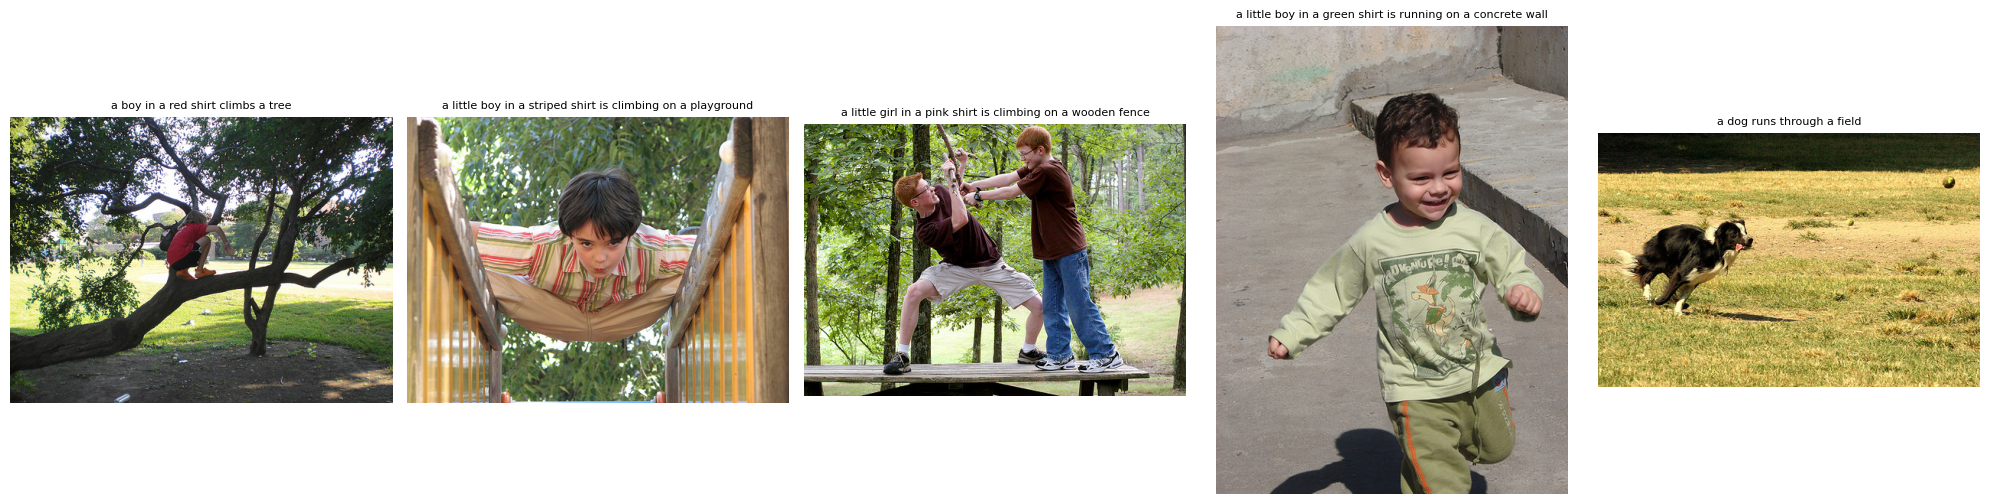

In [20]:
sample_indices = random.sample(range(len(dataset)), 5)

fig, axs = plt.subplots(1, 5, figsize=(20, 5))

for i, idx in enumerate(sample_indices):
    
    img_path = os.path.join(image_dir, dataset.imgs[idx])
    img = Image.open(img_path).convert("RGB")
    img_tensor = load_image_tensor(img_path, transform, device)

    
    caption = beam_search_caption(model, img_tensor, vocab, beam_size=4)

    
    axs[i].imshow(img)
    axs[i].set_title(caption, fontsize=8)
    axs[i].axis("off")

plt.tight_layout()
plt.show()


Generated Caption: a man in a white shirt is holding a camera


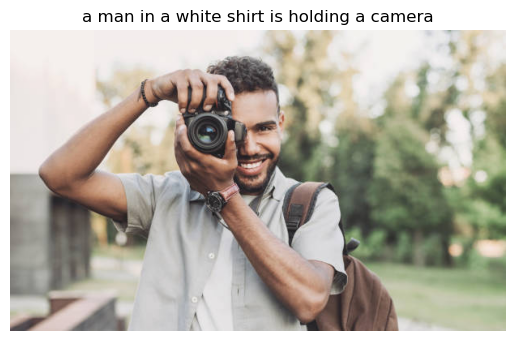

In [62]:

model.eval()
custom_image_path = "TestPic/bf72892be6a16588f569d6b7b1c53273.png"

img = Image.open(custom_image_path).convert("RGB")
img_tensor = load_image_tensor(custom_image_path, transform, device)

caption = beam_search_caption(model, img_tensor, vocab, beam_size=3)
print("Generated Caption:", caption)

plt.imshow(img)
plt.title(caption)
plt.axis("off")
plt.show()


In [48]:
print(img_tensor.shape)


torch.Size([1, 3, 224, 224])


In [50]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()


references_dict = {}
with open(captions_file, "r", encoding="utf-8") as f:
    next(f)
    for line in f:
        if "," in line:
            img, caption = line.strip().split(",", 1)
            references_dict.setdefault(img.strip(), []).append(caption.strip().lower())

val_image_names = []
for i in range(len(val_dataset)):
    original_idx = val_dataset.indices[i]
    img_name = dataset.imgs[original_idx] 
    val_image_names.append(img_name)

sample_images = random.sample(val_image_names, min(810, len(val_image_names)))

smoother = SmoothingFunction().method4
bleu_scores = []

for img_name in sample_images:
    img_path = os.path.join(image_dir, img_name)
    try:
        img_tensor = load_image_tensor(img_path, transform, device)
        pred_caption = beam_search_caption(model, img_tensor, vocab, beam_size=5).lower()

        reference_list = [ref.split() for ref in references_dict[img_name]]
        hypothesis = pred_caption.split()

        bleu = sentence_bleu(reference_list, hypothesis, smoothing_function=smoother)
        bleu_scores.append(bleu)

    except Exception as e:
        print(f"Error processing {img_name}: {e}")

if bleu_scores:
    avg_bleu = sum(bleu_scores) / len(bleu_scores)
    print(f"\nAverage BLEU on {len(bleu_scores)} val images: {avg_bleu:.4f}")
else:
    print("No BLEU scores computed.")




Average BLEU on 810 val images: 0.1858


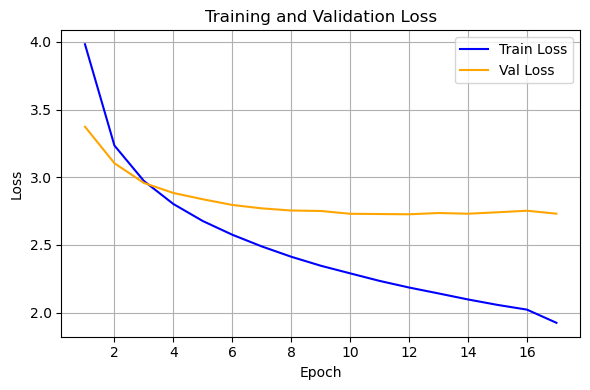

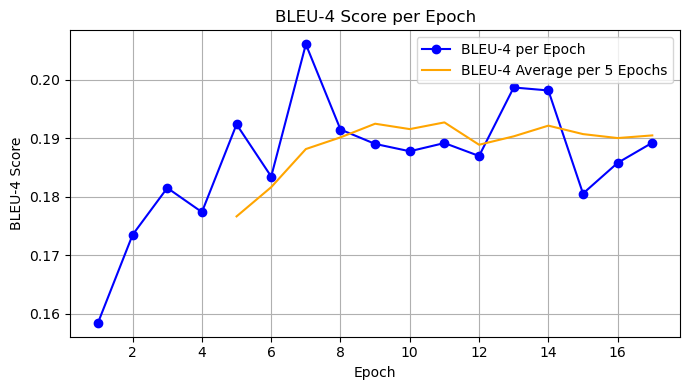

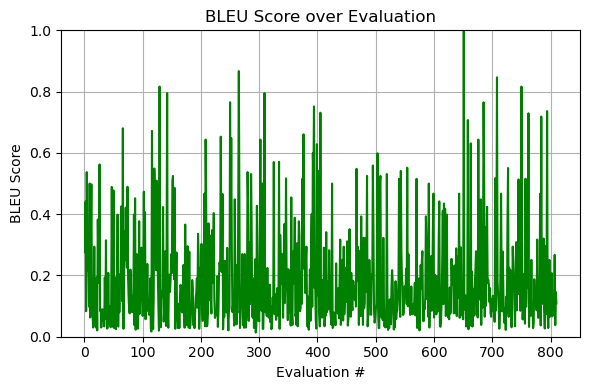

In [51]:

epochs = range(1, len(train_losses) + 1)

# ===  Loss  ===
plt.figure(figsize=(6, 4))
plt.plot(epochs, train_losses, label='Train Loss', color='blue')
plt.plot(epochs, val_losses, label='Val Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# === BLEU epoch VS 5-epoch Average ===
bleu_series = pd.Series(bleu4_scores)
rolling_bleu = bleu_series.rolling(window=5).mean()

plt.figure(figsize=(7, 4))
plt.plot(epochs, bleu4_scores, marker='o', label='BLEU-4 per Epoch', color='blue')
plt.plot(epochs, rolling_bleu, label='BLEU-4 Average per 5 Epochs', color='orange')
plt.xlabel('Epoch')
plt.ylabel('BLEU-4 Score')
plt.title('BLEU-4 Score per Epoch')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# === BLEU Evaluation score ===
plt.figure(figsize=(6, 4))
plt.plot(range(1, len(bleu_scores) + 1), bleu_scores, color='green')
plt.xlabel('Evaluation #')
plt.ylabel('BLEU Score')
plt.title('BLEU Score over Evaluation')
plt.ylim(0, 1)
plt.grid(True)
plt.tight_layout()
plt.show()
